In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import wave
import math
import scipy.fftpack
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile

import warnings
warnings.filterwarnings('ignore')

### [1/8] Generate a time-domain discrete signal
* Sampling rate fs = 4000 samples/second
* Signal x is a linear combination of two sine waves of central frequency 250Hz and 1000Hz

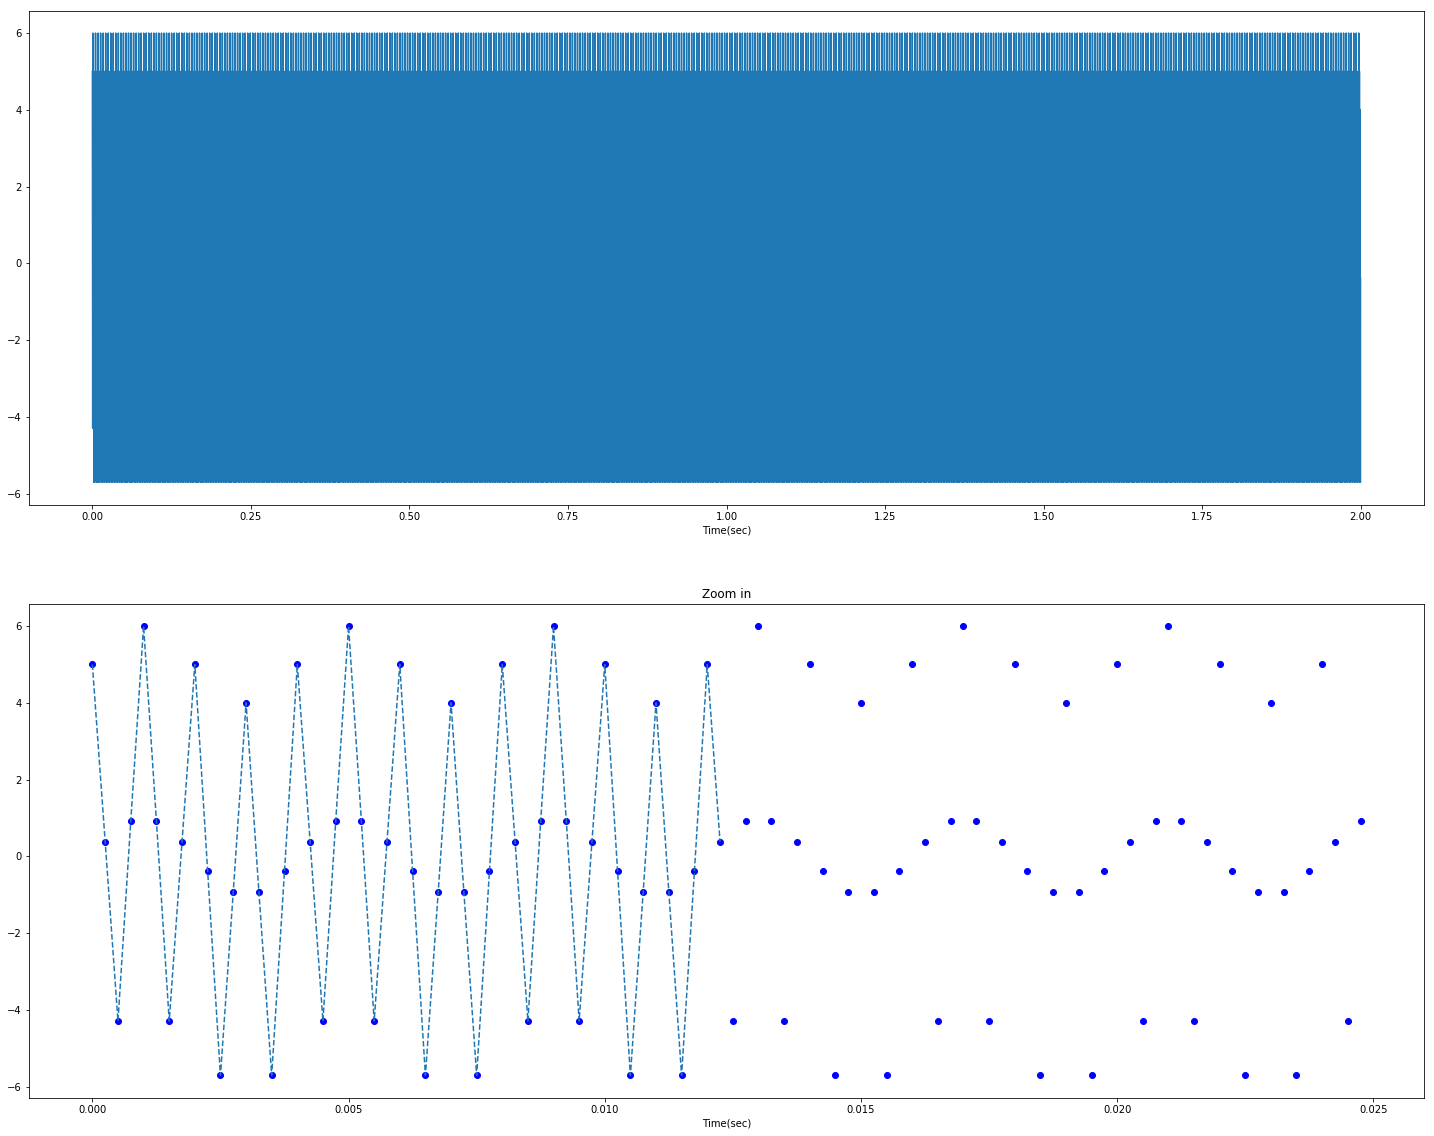

In [2]:
fs = 4000                      # sampling frequency should be 2x greater than signal's. (a.k.a. Nyquist's criterion) 
t = np.arange(0, 2.0, 1.0/fs)  # 2-sec-long interval, devided into 8000 pieces

fc_1 = 250   # central frequency 250Hz
fc_2 = 1000  # central frequency 1000Hz
x = np.sin(2*np.pi*fc_1*t) + 5*np.cos(2*np.pi*fc_2*t)  # Combination of two evenly sampled sine waves with different magnitudes.

plt.figure(figsize=(25,20))
plt.subplot(2,1,1)
plt.plot(t,x)
plt.xlabel('Time(sec)')
plt.subplot(2,1,2)
plt.title('Zoom in')
plt.xlabel('Time(sec)')
plt.plot(t[0:100], x[0:100],'bo')
plt.plot(t[0:50], x[0:50], '--')
plt.show()

### [2/8] Frequency-domain analysis - FFT
* The power of x is 0.5*(1^2 + 5^2) = 13
* By Parseval's theorem, calculating energy or power in time-domain is equivalent to frequency-domain
https://en.wikipedia.org/wiki/Parseval%27s_theorem
* Since we only use 200 points as input, the vacancy is padded with zero. The more zero padded the better resolution it is. However, it may introduce "power leakage" to sidelobe.
<br/>https://dsp.stackexchange.com/questions/741/why-should-i-zero-pad-a-signal-before-taking-the-fourier-transform
<br/>http://www.bitweenie.com/listings/fft-zero-padding/
<br/>https://en.wikipedia.org/wiki/Spectral_leakage

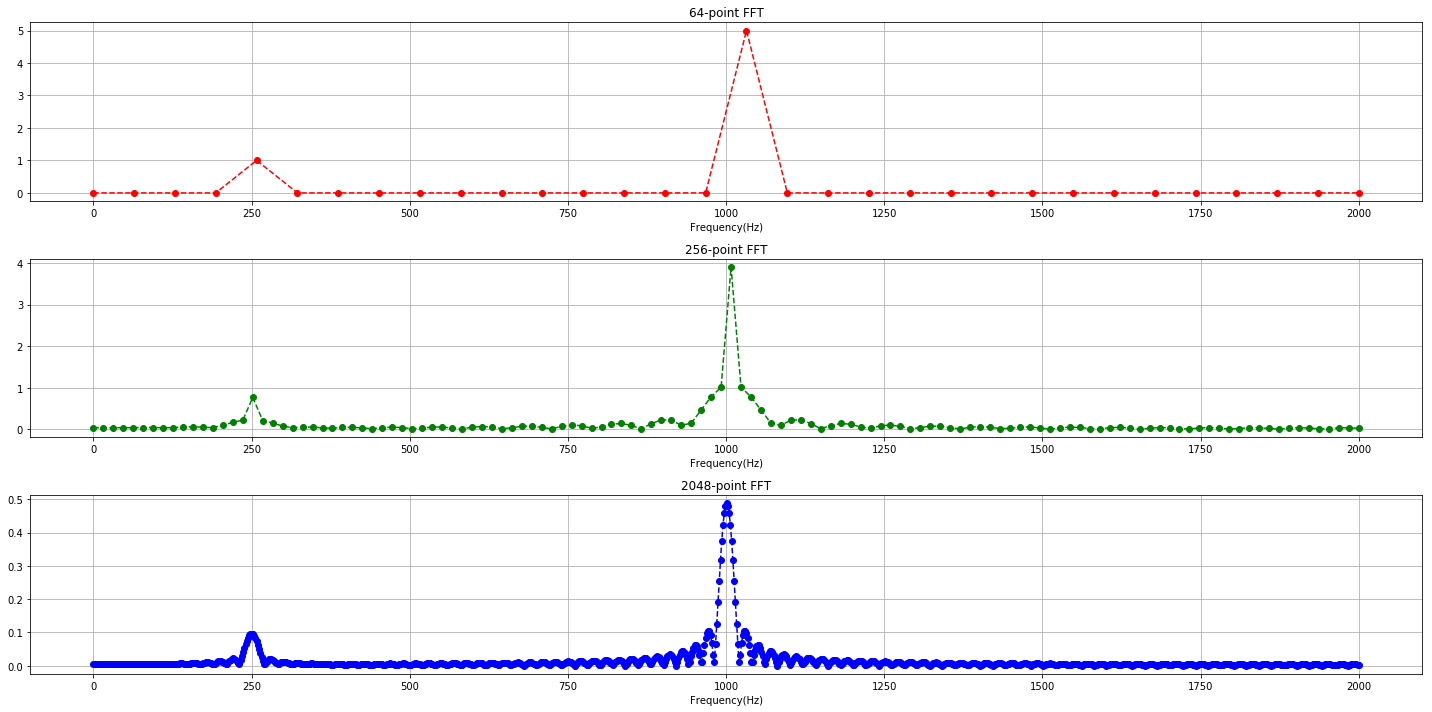

In [3]:
fft_input = x[0:200]  # pick 200 successive points as FFT input

# should be in power of 2
n_fft_64 = 64               
n_fft_256 = 256
n_fft_2048 = 2048

fft_output_64 = scipy.fftpack.fft(fft_input,n_fft_64)
fft_output_256 = scipy.fftpack.fft(fft_input,n_fft_256)
fft_output_2048 = scipy.fftpack.fft(fft_input,n_fft_2048)

# single-sided spectrum (no imaginary or minus frequency)
fft_output_64 = 2.0/n_fft_64 * np.abs(fft_output_64[:n_fft_64//2])  
fft_output_256 = 2.0/n_fft_256 * np.abs(fft_output_256[:n_fft_256//2])
fft_output_2048 = 2.0/n_fft_2048 * np.abs(fft_output_2048[:n_fft_2048//2])

# devided into n_fft bins
freq_64 = np.linspace(0.0, fs/2, n_fft_64//2) 
freq_256 = np.linspace(0.0, fs/2, n_fft_256//2)
freq_2048 = np.linspace(0.0, fs/2, n_fft_2048//2)

# visualize
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.title('64-point FFT')
plt.xlabel('Frequency(Hz)')
plt.plot(freq_64,fft_output_64,'r--',marker='o')
plt.grid()
plt.subplot(3,1,2)
plt.title('256-point FFT')
plt.xlabel('Frequency(Hz)')
plt.plot(freq_256,fft_output_256,'g--',marker='o')
plt.grid()
plt.subplot(3,1,3)
plt.title('2048-point FFT')
plt.xlabel('Frequency(Hz)')
plt.plot(freq_2048,fft_output_2048,'b--',marker='o')
plt.grid()
plt.tight_layout()
plt.show()

### [3/8] Windowed FFT
* Using Hamming window before FFT to mitigate power leakage.
* Always window before zero-padding.

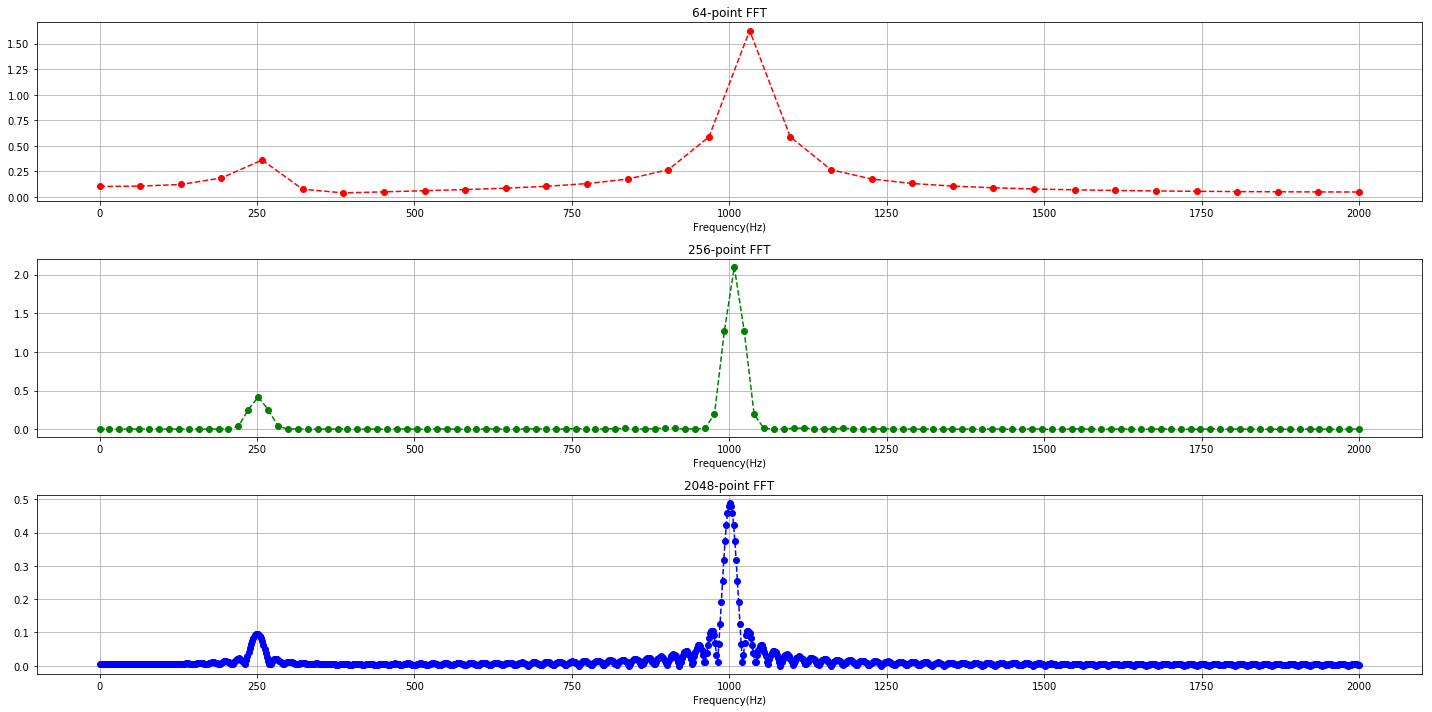

In [4]:
fft_input = fft_input * signal.hamming(len(fft_input))

# should be in power of 2
n_fft_64 = 64               
n_fft_256 = 256
n_fft_1024 = 1024

fft_output_64 = scipy.fftpack.fft(fft_input,n_fft_64)
fft_output_256 = scipy.fftpack.fft(fft_input,n_fft_256)
fft_output_1024 = scipy.fftpack.fft(fft_input,n_fft_1024)

# single-sided spectrum (no imaginary number or minus frequency)
fft_output_64 = 2.0/n_fft_64 * np.abs(fft_output_64[:n_fft_64//2])  
fft_output_256 = 2.0/n_fft_256 * np.abs(fft_output_256[:n_fft_256//2])
fft_output_1024 = 2.0/n_fft_1024 * np.abs(fft_output_1024[:n_fft_1024//2])

# devided into n_fft bins
freq_64 = np.linspace(0.0, fs/2, n_fft_64//2) 
freq_256 = np.linspace(0.0, fs/2, n_fft_256//2)
freq_1024 = np.linspace(0.0, fs/2, n_fft_1024//2)

# visualize
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.title('64-point FFT')
plt.xlabel('Frequency(Hz)')
plt.plot(freq_64,fft_output_64,'r--',marker='o')
plt.grid()
plt.subplot(3,1,2)
plt.title('256-point FFT')
plt.xlabel('Frequency(Hz)')
plt.plot(freq_256,fft_output_256,'g--',marker='o')
plt.grid()
plt.subplot(3,1,3)
plt.title('2048-point FFT')
plt.xlabel('Frequency(Hz)')
plt.plot(freq_2048,fft_output_2048,'b--',marker='o')
plt.grid()
plt.tight_layout()
plt.show()

### [4/8] STFT Spectrogram
* A comparison between normal and narrower windows.
* We can inspect the frequency composition and the corresponding time in STFT spectrogram.
* Narrow window = good time resolution = poor frequency resolution

In [6]:
from wavhandler import * 
from utils import *
from utils_train import *

X_names, y = get_data(only_names=True)

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [5]:
filepath = './normal_201103101140.wav'
fs, samples = wavfile.read(filepath)
stft_input,sr = librosa.load(filepath, sr=None)

window = signal.kaiser(2048, beta=1)
window_narrow = signal.kaiser(2048, beta=21)   

stft_output = librosa.stft(stft_input, window=window,center=False)
stft_output_narrow = librosa.stft(stft_input, window=window_narrow,center=False)  #narrower window

# visualize
plt.figure(figsize=(15.75,10))
ax1 = plt.subplot(3,1,1)
plt.title('Normal Heart Sound')
plt.xlabel('Time(sec)')
plt.plot(np.linspace(0, len(samples)//fs,len(samples)), samples)
plt.xlim(xmin=0)
plt.grid()
plt.figure(figsize=(25,10))
plt.subplot(3,1,2, sharex=ax1)
librosa.display.specshow(librosa.amplitude_to_db(stft_output, ref=1), y_axis='log', x_axis='time',sr=sr)
plt.title('Power spectrogram')
plt.colorbar()
plt.subplot(3,1,3,sharex=ax1)
librosa.display.specshow(librosa.amplitude_to_db(stft_output_narrow, ref=1), y_axis='log', x_axis='time',sr=sr)
plt.title('Power spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './normal_201103101140.wav'

### [5/8] Learn more about window

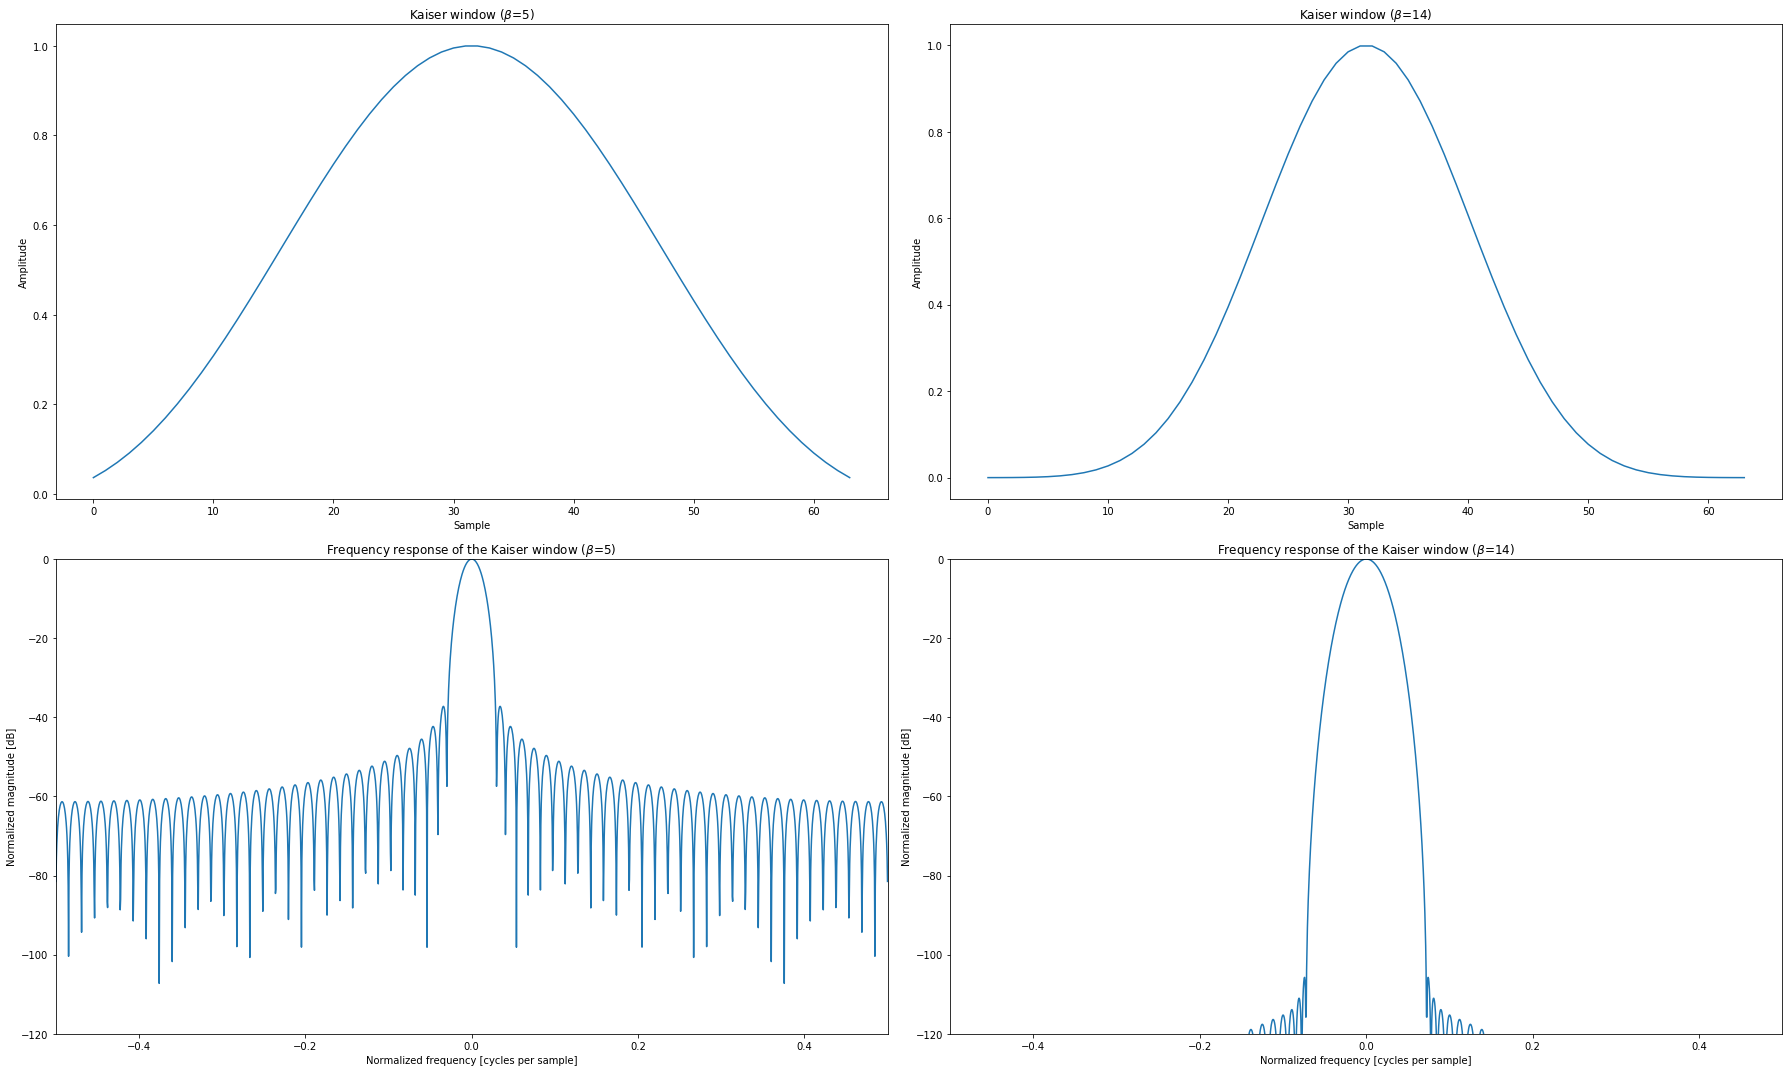

In [6]:
window = signal.kaiser(64, beta=5)
window_narrow = signal.kaiser(64, beta=14)

# visualize
plt.figure(figsize=(25,15))
gs = gridspec.GridSpec(2, 2)
plt.subplot(gs[0, 0])
plt.plot(window)
plt.title(r"Kaiser window ($\beta$=5)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.subplot(gs[1, 0])
A = scipy.fftpack.fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(scipy.fftpack.fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title(r"Frequency response of the Kaiser window ($\beta$=5)")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

plt.subplot(gs[0, 1])
plt.plot(window_narrow)
plt.title(r"Kaiser window ($\beta$=14)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.subplot(gs[1, 1])
A = scipy.fftpack.fft(window_narrow, 2048) / (len(window_narrow)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(scipy.fftpack.fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title(r"Frequency response of the Kaiser window ($\beta$=14)")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.tight_layout()
plt.show()

### [6/8] Normal v.s. murmur heartbeat in STFT

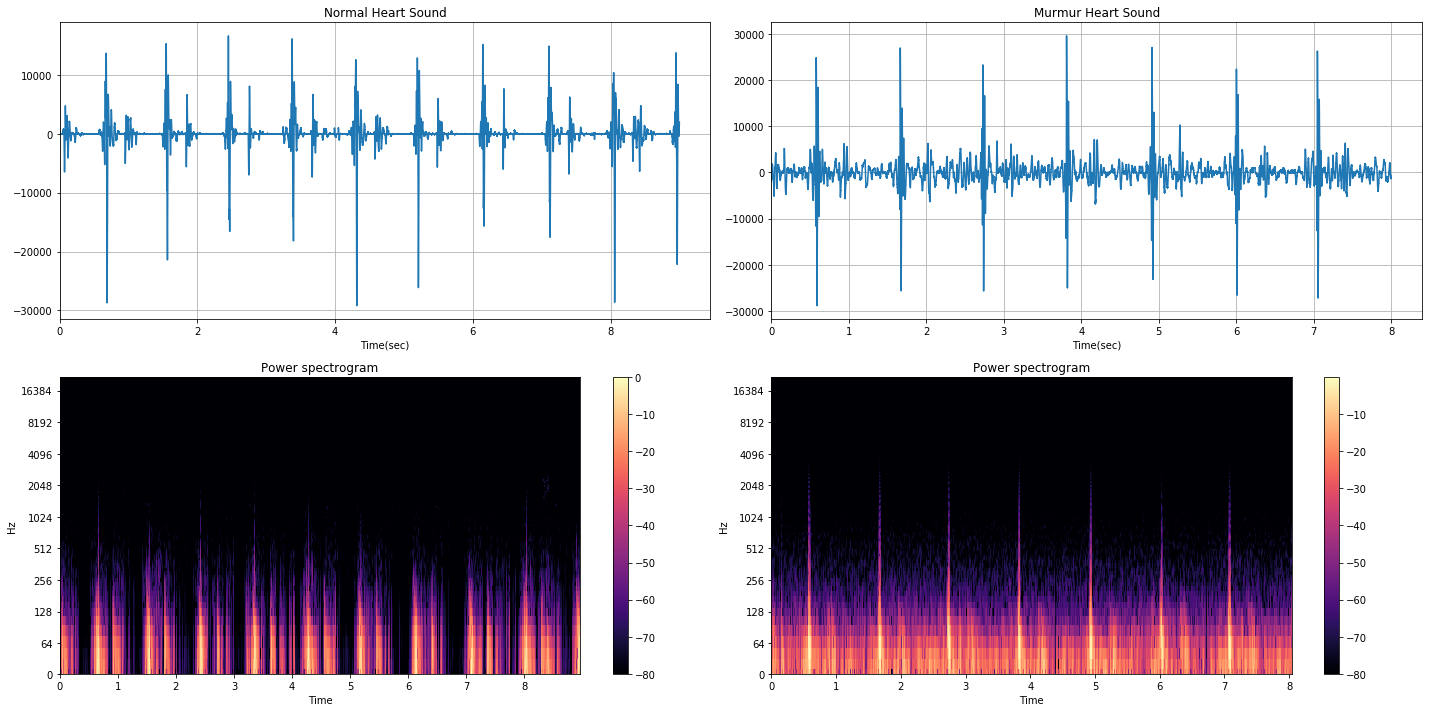

In [7]:
filepath = './murmur_201101180902.wav'
fs, samples_murmur = wavfile.read(filepath)

window_narrow = signal.kaiser(2048, beta=14)
stft_input_murmur,sr = librosa.load(filepath, sr=None)
stft_output_murmur = librosa.stft(stft_input_murmur,window=window_narrow)  # both use narrow window
  
# visualize
plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 2)
plt.subplot(gs[0, 0])
plt.title('Normal Heart Sound')
plt.xlabel('Time(sec)')
plt.plot(np.linspace(0.0, len(samples)//fs,len(samples)), samples)
plt.xlim(xmin=0)
plt.grid()

plt.subplot(gs[0, 1])
plt.title('Murmur Heart Sound')
plt.xlabel('Time(sec)')
plt.plot(np.linspace(0.0, len(samples_murmur)//fs,len(samples_murmur)), samples_murmur)
plt.xlim(xmin=0)
plt.grid()

plt.subplot(gs[1, 0])
librosa.display.specshow(librosa.amplitude_to_db(stft_output_narrow, ref=np.max), y_axis='log', x_axis='time',sr=sr)
plt.title('Power spectrogram')
plt.colorbar()

plt.subplot(gs[1, 1])
librosa.display.specshow(librosa.amplitude_to_db(stft_output_murmur, ref=np.max), y_axis='log', x_axis='time',sr=sr)
plt.title('Power spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

### [7/8] Continuous wavelet transform
* First and foremost, many thanks to Prof. Robi Polikar for making this comprehensive tutorial.
<br/>http://users.rowan.edu/~polikar/WTtutorial.html

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


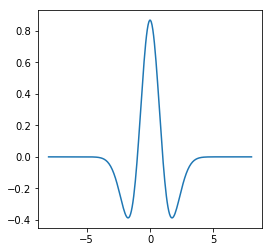

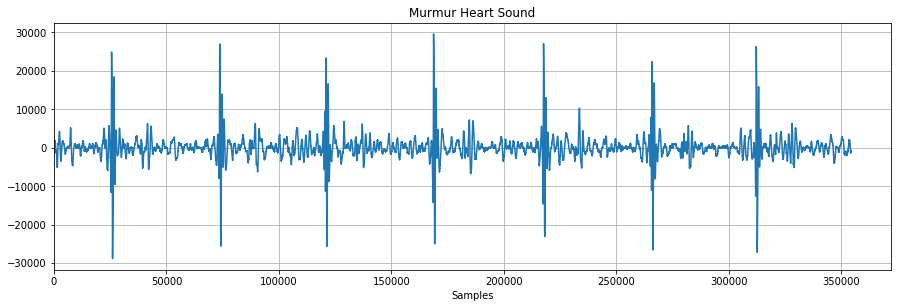

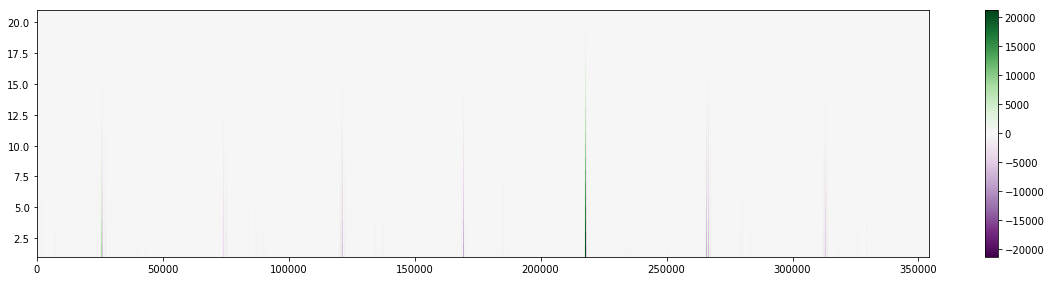

In [8]:
import pywt

continuous_wavelet = pywt.ContinuousWavelet('mexh')
print(continuous_wavelet)

max_scale = 20
scales = np.arange(1, max_scale + 1)
cwtmatr, freqs = pywt.cwt(samples_murmur, scales, continuous_wavelet, 44100)

# visualize
plt.figure(figsize=(4,4))
(phi, psi) = continuous_wavelet.wavefun()
plt.plot(psi,phi)
plt.show()
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Murmur Heart Sound')
plt.xlabel('Samples')
plt.plot(np.linspace(0.0, len(samples_murmur),len(samples_murmur)), samples_murmur)
plt.xlim(xmin=0)
plt.grid()

plt.figure(figsize=(20,10))
plt.subplot(2,1,2)
plt.imshow(cwtmatr, extent=[0, int(len(samples_murmur)), 1, max_scale + 1],cmap='PRGn', aspect='auto', 
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar()

plt.show() 

### [8/8] Discrete wavelet transform

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False
MAXIMUM DECOMPOSE LEVEL =  16


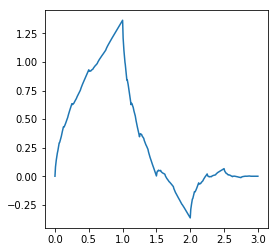

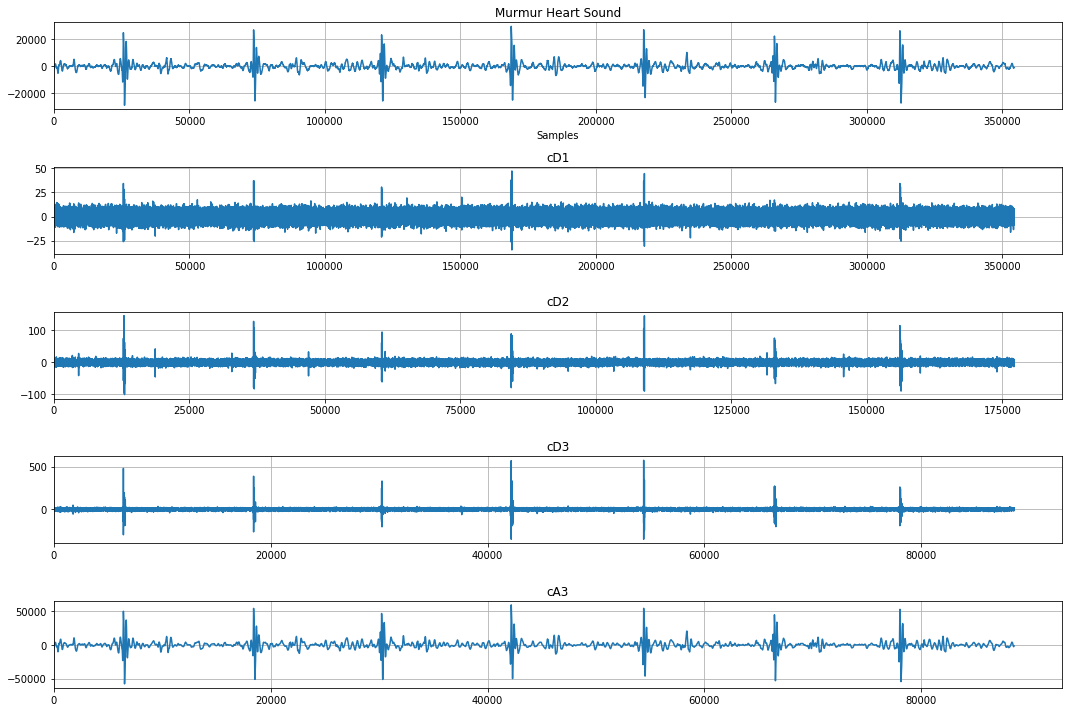

In [9]:
discrete_wavelet = pywt.Wavelet('db2')
print(discrete_wavelet)

max_level = pywt.dwt_max_level(len(samples_murmur), discrete_wavelet)
print('MAXIMUM DECOMPOSE LEVEL = ',max_level)

# decompose
tree = pywt.wavedec(samples_murmur, 'db2',level=3)
cA3, cD3, cD2, cD1 = tree
#print(len(cD1),len(cD2),len(cD3),len(cA3))

# reconstruct
rec_sample = pywt.waverec(tree, 'db2')
rec_to_orig = pywt.idwt(None, cD1, 'db2', 'smooth')  #
rec_to_level1 = pywt.idwt(None, cD2, 'db2', 'smooth')
rec_to_level2_from_detail = pywt.idwt(None, cD3, 'db2', 'smooth')
rec_to_level2_from_approx = pywt.idwt(cA3, None, 'db2', 'smooth')
#print(len(rec_to_orig),len(rec_to_level1),len(rec_to_level2_from_detail),len(rec_to_level2_from_approx))

# visualize
plt.figure(figsize=(4,4))
(phi, psi, x) = discrete_wavelet.wavefun()
plt.plot(x, phi)
plt.show()
plt.figure(figsize=(15,10))
plt.subplot(5,1,1)
plt.title('Murmur Heart Sound')
plt.xlabel('Samples')
plt.plot(np.linspace(0.0, len(samples_murmur),len(samples_murmur)), samples_murmur)
plt.xlim(xmin=0)
plt.grid()

plt.subplot(5,1,2)
plt.title('cD1')
plt.plot(np.linspace(0.0, len(rec_to_orig),len(rec_to_orig)), rec_to_orig)
plt.xlim(xmin=0)
plt.grid()
plt.subplot(5,1,3)
plt.title('cD2')
plt.plot(np.linspace(0.0, len(rec_to_level1),len(rec_to_level1)), rec_to_level1)
plt.xlim(xmin=0)
plt.grid()
plt.subplot(5,1,4)
plt.title('cD3')
plt.plot(np.linspace(0.0, len(rec_to_level2_from_detail),len(rec_to_level2_from_detail)), rec_to_level2_from_detail)
plt.xlim(xmin=0)
plt.grid()
plt.subplot(5,1,5)
plt.title('cA3')
plt.plot(np.linspace(0.0, len(rec_to_level2_from_approx),len(rec_to_level2_from_approx)), rec_to_level2_from_approx)
plt.xlim(xmin=0)
plt.grid()
plt.tight_layout()
plt.show() 